## Stock Portfolio Optimization

Use the `faang_stocks.csv` dataset to complete the following analysis:

* What are the expected returns and the annualized Sharpe ratio of an equally-weighted portfolio? Assume the risk-free rate is 0% and store your answers as a float variables called benchmark_exp_return and benchmark_sharpe_ratio.

* Find a portfolio that minimizes volatility. Use mean-variance optimization. Store the volatility of the portfolio as a float variable called mv_portfolio_vol. Store the portfolio weights as a pandas Series called mv_portfolio. Use the tickers as index.

* Find a portfolio that maximizes the Sharpe ratio. Use mean-variance optimization and keep the risk-free rate at 0%. Store the Sharpe ratio (annualized) of the portfolio as a float variable called ms_portfolio_sharpe. Store the portfolio weights as a pandas Series called ms_portfolio. Use the tickers as index.

<br>

Asset allocation is the most important decision that any investor needs to face. They need to decide how to spread their total capital over certain assets (in this case, stocks). When considering the allocation, the investor wants to balance the risk and the potential reward. At the same time, the allocation depends on factors such as individual goals, risk tolerance, and the investment horizon.

The key framework used in asset allocation is the Modern Portfolio Theory (MPT), which was introduced by the Nobel Prize winner Harry Markowitz. MPT describes how investors can construct portfolios to maximize their expected returns for a given level of risk or, conversely, minimize risk for a given level of expected return. The mathematical framework used to achieve this is called mean-variance optimization.

The main insight from MPT is that investors should not evaluate an asset’s performance alone. Instead, they should evaluate how it would impact the performance of a portfolio of assets. Another important takeaway is the concept of diversification, which means that owning different kinds of assets reduces risk. That is because the loss or gain of a particular security has less impact on the overall portfolio’s performance.

<br>

In the dynamic realm of finance, data scientists/analysts are often tasked with finding optimal investment strategies. Imagine you're one such analyst, and you were asked to build an effective portfolio comprising FAANG stocks – Facebook (Meta), Apple, Amazon, Netflix, and Google. The goal is to maximize returns while mitigating risk.

You are tasked to find the optimal allocation to the FAANG stocks based on historical stock price data spanning the years 2020-2023. The dataset is stored in the `faang_stocks.csv` file. For each trading day, it contains the close prices of the five tech companies.


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
# Setting the plotting style to be colorblind-friendly
# plt.style.use("seaborn-v0_8-colorblind")
# plt.style.use("dark_background")
plt.style.use("seaborn-v0_8-dark-palette")


# Loading data
stock_prices_df = pd.read_csv("../data_raw/faang_stocks.csv", index_col="Date")

# Changing the index to a datetime type allows for easier filtering and plotting.
stock_prices_df.index = pd.to_datetime(stock_prices_df.index)
stock_prices_df

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-02,75.09,94.90,68.43,209.78,329.81
2020-01-03,74.36,93.75,68.08,208.67,325.90
2020-01-06,74.95,95.14,69.89,212.60,335.83
2020-01-07,74.60,95.34,69.76,213.06,330.75
2020-01-08,75.80,94.60,70.25,215.22,339.26
...,...,...,...,...,...
2023-12-22,193.60,153.42,141.49,353.39,486.76
2023-12-26,193.05,153.41,141.52,354.83,491.19
2023-12-27,193.15,153.34,140.37,357.83,491.79


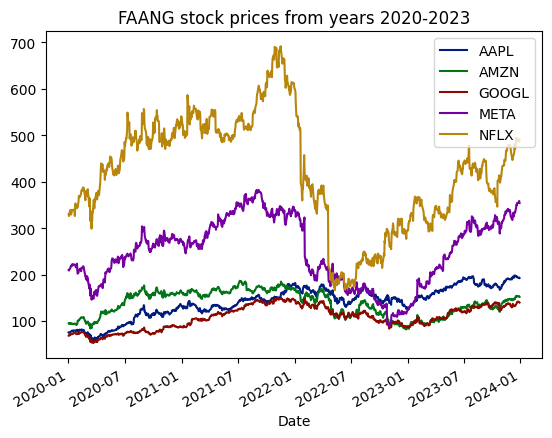

In [4]:
# Plotting the stock prices
stock_prices_df.plot(title="FAANG stock prices from years 2020-2023");

In [5]:
# Task 1 ---------------------------------------------------

# Calculate returns
returns_df = stock_prices_df.pct_change().dropna()

# Calculate the 1/n portfolio weights
portfolio_weights = 5 * [0.2]

# Calculate the portfolio returns of the 1/n portfolio
portfolio_returns = returns_df.dot(portfolio_weights)

# Calculate the expected portfolio return
benchmark_exp_return = portfolio_returns.mean()

# Calculate the portfolio's Sharpe ratio
benchmark_sharpe_ratio = (
    portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
)

In [6]:
# Task 2 ---------------------------------------------------

# Calculate the annualized expected returns and the covariance matrix
avg_returns = returns_df.mean() * 252
cov_mat = returns_df.cov() * 252

# Instantiate the EfficientFrontier object
ef = EfficientFrontier(avg_returns, cov_mat)

# Find the weights that maximize the Sharpe ratio
weights = ef.min_volatility()
mv_portfolio = pd.Series(weights)

# Find the minimized volatility
mv_portfolio_vol = ef.portfolio_performance(risk_free_rate=0)[1]

In [7]:
# Task 2 - alternative solution ----------------------------

# # Calculate the annualized expected returns and the covariance matrix
# avg_returns = returns_df.mean() * 252
# cov_mat = returns_df.cov() * 252

# # Define the function to find the portfolio volatility using the weights and the covariance matrix
# def get_portfolio_volatility(weights, cov_mat):
#     return np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
  
# # Define the number of assets
# n_assets = len(avg_returns)

# # Define the bounds - the weights can be between 0 and 1
# bounds = tuple((0, 1) for asset in range(n_assets))

# # Define the initial guess - the equally weighted portfolio
# initial_guess = n_assets * [1.0 / n_assets]

# # Define the constraint - all weights must add up to 1
# constr = {"type": "eq", "fun": lambda x: np.sum(x) - 1}

# # Find the minimum volatility portfolio
# result = sco.minimize(
#     get_portfolio_volatility,
#     x0=initial_guess,
#     args=cov_mat,
#     method="SLSQP",
#     constraints=constr,
#     bounds=bounds,
# )

# # Store the portfolio weights
# mv_portfolio = pd.Series(result.x, index=avg_returns.index).round(2)

# # Store the portfolio's volatility
# mv_portfolio_vol = result.fun


In [8]:
# Task 3 ---------------------------------------------------

# Alternative approach to get the expected returns and the covariance matrix
# avg_returns = expected_returns.mean_historical_return(stock_prices_df, compounding=False)
# cov_mat = risk_models.sample_cov(stock_prices_df)

# Instantiate the EfficientFrontier object
ef = EfficientFrontier(avg_returns, cov_mat)

# Find the weights that maximize the Sharpe ratio
weights = ef.max_sharpe(risk_free_rate=0)
ms_portfolio = pd.Series(weights)

# Find the maximized Sharpe ratio
ms_portfolio_sharpe = ef.portfolio_performance(risk_free_rate=0)[2]

In [ ]:
# jupyter nbconvert --to html stock-portfolio-analysis.ipynb